In [ ]:
!pip install matplotlib

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00


In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255318 sha256=7032f2013641e5a49b734ff169f878c1172bfce28cb81d51c0a5695cee588934
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


# Forecast de Preço do Petroleo Brent (SARIMA e LSTM)

### Importação de Módulos

In [ ]:
# Required modules

# For common operations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose # For time series decomposition
from pmdarima import auto_arima


# For LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model  # Allows load a previously saved model.

# To evaluate the models
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
import joblib

In [ ]:
import xlsxwriter

## Data Loading and Cleaning

### IPEA Data Loading

In [ ]:
raw_list = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view',
                      encoding='UTF-8')

In [ ]:
df_brent = raw_list[2]
df_brent.columns = ['date','brent_crude_oil']
df_brent = df_brent.drop(0)
df_brent['date'] = pd.to_datetime(df_brent['date'],format='%d/%m/%Y')
df_brent = df_brent.astype({'brent_crude_oil':'float64'})
df_brent['brent_crude_oil'] = df_brent['brent_crude_oil'] / 100
df_brent = df_brent.set_index('date')
df_brent.sort_values(by='date', inplace=True)


In [ ]:
df_brent.drop_duplicates(inplace=True)

In [ ]:
df_brent = df_brent.squeeze()
df_brent = df_brent.asfreq('B')

In [ ]:
df_brent.fillna(method='ffill', inplace=True)

In [ ]:
data = df_brent

In [ ]:
data

date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.60
              ...  
2024-05-07    88.23
2024-05-08    82.44
2024-05-09    83.27
2024-05-10    83.39
2024-05-13    83.18
Freq: B, Name: brent_crude_oil, Length: 9649, dtype: float64

### Análise dos Dados

count    9649.000000
mean       49.934975
std        33.021147
min         9.100000
25%        20.010000
50%        42.420000
75%        74.120000
max       143.950000
Name: brent_crude_oil, dtype: float64


<class 'pandas.core.series.Series'>
DatetimeIndex: 9649 entries, 1987-05-20 to 2024-05-13
Freq: B
Series name: brent_crude_oil
Non-Null Count  Dtype  
--------------  -----  
9649 non-null   float64
dtypes: float64(1)
memory usage: 150.8 KB
None
Missing values:  0


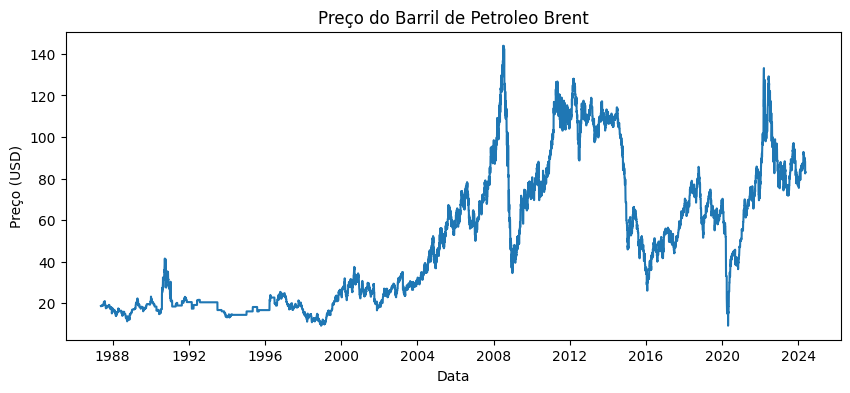

In [ ]:
# Basic EDA of the data
print(data.describe())
print('\n')
print(data.info())
print('Missing values: ', data.isna().sum())

# Plots the data
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title('Preço do Barril de Petroleo Brent')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()

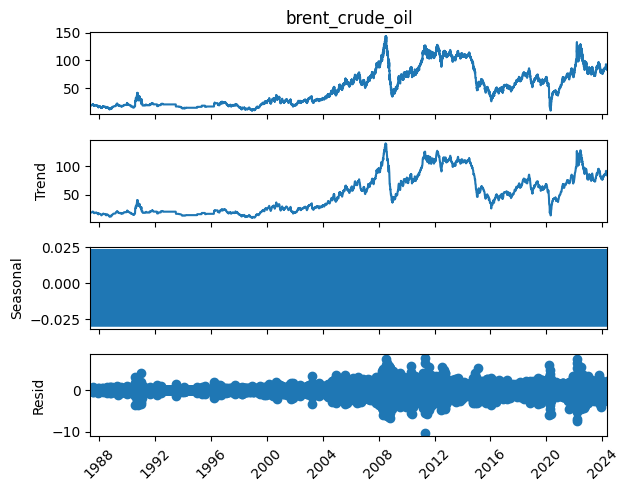

In [ ]:
# Decomposição dos Dados
seasonal_decompose(data).plot()
plt.xticks(rotation=45)
plt.show()

### Teste ADF

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    df_test = pd.DataFrame(timeseries)
    adf_result = adfuller(df_test['brent_crude_oil'])
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Resultados do Teste de Estacionariedade:')
    print('--------------------------------------')
    print('Teste Estatístico:', adf_result[0])
    print('Valor-p:', adf_result[1])
    print('Valores Críticos:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')


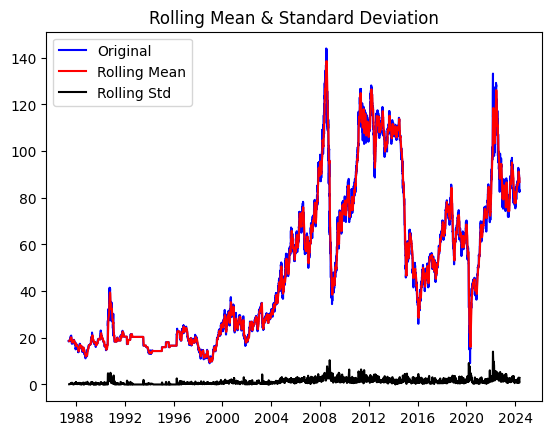

ADF Statistic: -2.1379787953630607
p-value: 0.22951979500192166
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.1379787953630607
Valor-p: 0.22951979500192166
Valores Críticos:
   1%: -3.4310300838145107
   5%: -2.8618405552764714
   10%: -2.5669299804591974


In [ ]:
test_stationarity(data)

Modelo de Série Não Estacionário

Transformando a série em Logarítimica

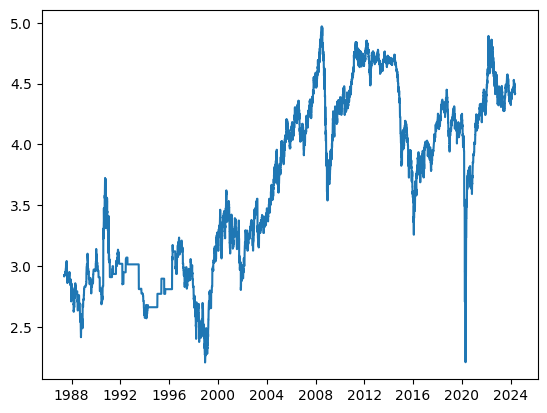

In [ ]:
#Transformação Logarítimca
indexedDataset_logScale = np.log(data)
plt.plot(indexedDataset_logScale)

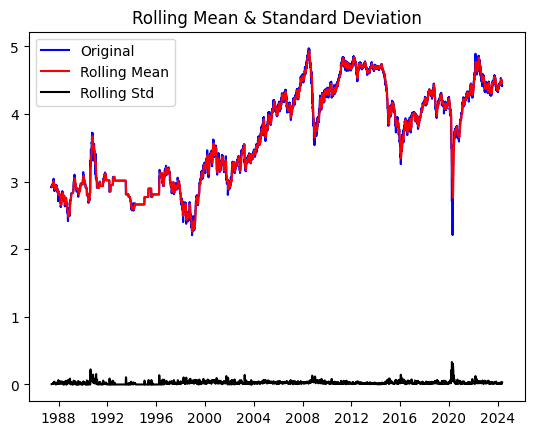

ADF Statistic: -1.8037135368792545
p-value: 0.37861959049650395
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.8037135368792545
Valor-p: 0.37861959049650395
Valores Críticos:
   1%: -3.4310302253006775
   5%: -2.861840617797508
   10%: -2.5669300137393205


In [ ]:
test_stationarity(indexedDataset_logScale)

Série Logarítimica continua não estacionária

Transformação a Serie com Diferenciação

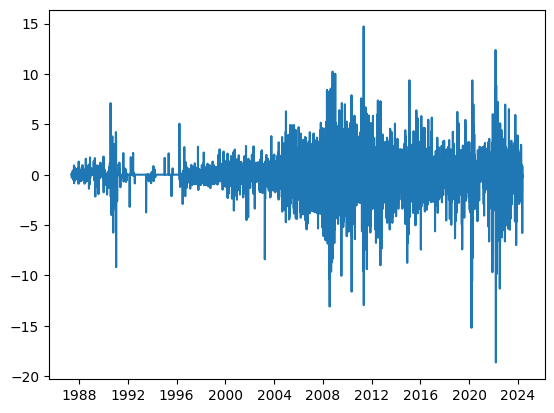

In [ ]:
indexedDataset_DifScale = data.diff()
indexedDataset_DifScale = indexedDataset_DifScale.dropna()

plt.plot(indexedDataset_DifScale)

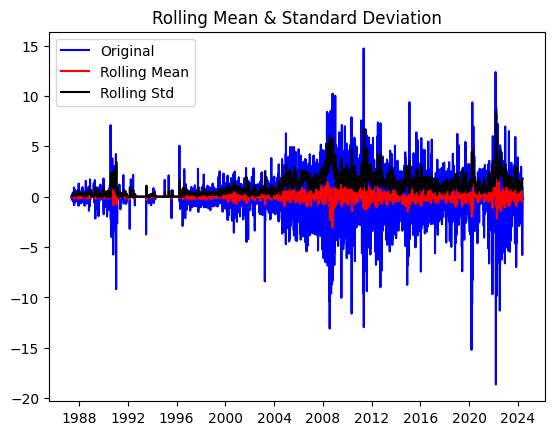

ADF Statistic: -16.00148185927006
p-value: 6.503934881190666e-29
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -16.00148185927006
Valor-p: 6.503934881190666e-29
Valores Críticos:
   1%: -3.4310300838145107
   5%: -2.8618405552764714
   10%: -2.5669299804591974


In [ ]:
test_stationarity(indexedDataset_DifScale)

Série Diferencial Estacionária

Pode ser usada no modelo SARIMA porque é Estacionária

## SARIMA model

### Data Spliting

In [ ]:
train_data = data.iloc[:len(data) - 30]
test_data = data.iloc[len(data) - 30:]

print(len(train_data))
print(len (test_data))

9619
30


### Pegando os parâmetros para o modelo SARIMA

In [ ]:
opt_model = auto_arima(train_data, maxiter=100, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34247.397, Time=5.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34723.563, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34673.002, Time=1.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34638.754, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34721.782, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34289.967, Time=3.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=34249.449, Time=3.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=34233.991, Time=14.95 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=34233.136, Time=17.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34248.017, Time=3.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=34233.897, Time=21.50 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34254.082, Time=1.54 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=34245.139, Time=2.89 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=34234.864, Time=18.61 sec
 ARIMA(3,1,1)(0

### Model training

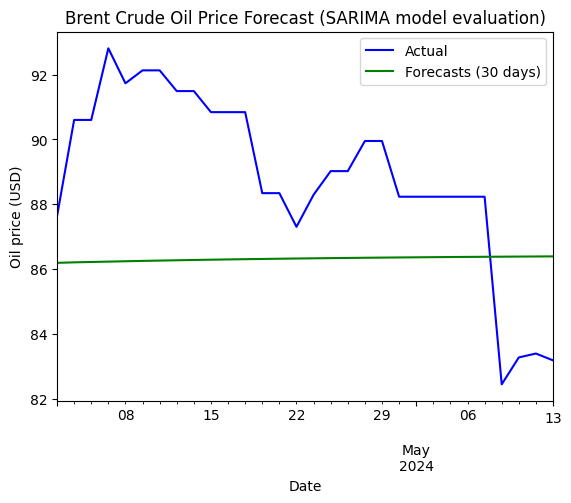

In [ ]:
# Trains the model according to the auto_arima output -> (3,1,1)x(0,0,0,0)
sarima_model_eval = SARIMAX(train_data, order=(3, 1, 1), seasonal_order=(0, 0, 0, 0))
estimator_eval = sarima_model_eval.fit()

# Gets forecast for evaluation
preds = estimator_eval.forecast(len(test_data))

# Plot the results
test_data.plot(color='blue', label='Actual')
preds.plot(color='green', label='Forecasts (30 days)')

plt.title('Brent Crude Oil Price Forecast (SARIMA model evaluation)')
plt.xlabel('Date')
plt.ylabel('Oil price (USD)')
plt.legend()
plt.show()

### Model evaluation

In [ ]:
rmse = np.sqrt(mean_squared_error(test_data.values, preds.values))
mae = mean_absolute_error(test_data.values, preds.values)
mape = mean_absolute_percentage_error(test_data.values, preds.values)

print('Root Mean Square Error (RMSE): {} \nMean Absolute Error (MAE): {} \nMean Absolute Percentage Error (MAPE): {}'. format(np.round(rmse, 3), np.round(mae, 3), np.round(mape, 3)))

Root Mean Square Error (RMSE): 3.734 
Mean Absolute Error (MAE): 3.404 
Mean Absolute Percentage Error (MAPE): 0.038


### Using the model to forecasts Brent crude oil price for the following 15 days

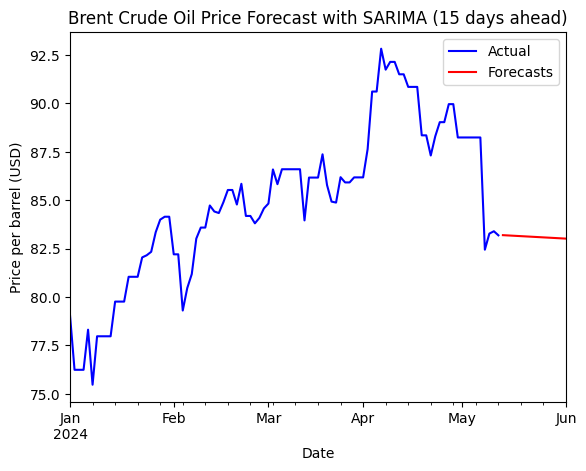

Forecasts for the following 15 days: 

2024-05-14    83.188632
2024-05-15    83.175863
2024-05-16    83.163095
2024-05-17    83.150330
2024-05-20    83.137566
2024-05-21    83.124804
2024-05-22    83.112045
2024-05-23    83.099287
2024-05-24    83.086531
2024-05-27    83.073778
2024-05-28    83.061026
2024-05-29    83.048276
2024-05-30    83.035528
2024-05-31    83.022782
2024-06-03    83.010038
Freq: B, Name: predicted_mean, dtype: float64


In [ ]:
# Sets the model
sarima_model_forecast = SARIMAX(data, order=(1,0,1), seasonal_order=(0,0,0,0))
estimator_forecast = sarima_model_forecast.fit()

# Makes predictions
steps_ahead = 15
forecasts = estimator_forecast.forecast(steps_ahead)
ci = estimator_forecast.conf_int()

# Displays the results
short_data = data[data.index.year >= 2024]
short_data.plot(color='blue', label='Actual')
forecasts.plot(color='red', label='Forecasts')

plt.title('Brent Crude Oil Price Forecast with SARIMA (15 days ahead)')
plt.xlabel('Date')
plt.ylabel('Price per barrel (USD)')
plt.legend()
plt.show()

print('Forecasts for the following {} days: \n'.format(steps_ahead))
print(forecasts)

In [ ]:
df_arima = pd.DataFrame(forecasts)
df_arima.index = pd.to_datetime(df_arima.index, format = '%Y-%m-%d').strftime('%d/%m/%Y')
df_arima.rename(columns={"predicted_mean": "Forecast ARIMA"}, inplace=True)


In [ ]:
df_arima.head(15)

,Forecast ARIMA
14/05/2024,83.188632
15/05/2024,83.175863
16/05/2024,83.163095
17/05/2024,83.150330
20/05/2024,83.137566
21/05/2024,83.124804
22/05/2024,83.112045
23/05/2024,83.099287
24/05/2024,83.086531
27/05/2024,83.073778


## LSTM model

### Data preparation

In [ ]:
train_data = data.iloc[:len(data) - 30]
test_data = data.iloc[len(data) - 30:]

print(len(train_data))
print(len (test_data))

9619
30


In [ ]:
# Reshapes the data to feed the model
full_data_lstm = data.values.reshape(-1, 1)
train_data_lstm = train_data.values.reshape(-1, 1)
test_data_lstm = test_data.values.reshape(-1, 1)

# Defines train and test sets
X_train = []
y_train = []
ws = 30 # Window size: indicates the number of previous time steps. The more, may lead to higher accuracy, but increases complexity and training time.

for i in range(ws, len(train_data_lstm)):
    X_train.append(train_data_lstm[i - ws: i])
    y_train.append(train_data_lstm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

### Model training
The model hyperparameters were chosen after evaluating many different combinations.

In [ ]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape = (X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=600)

Epoch 1/100
16/16 [==============================] - 10s 426ms/step - loss: 1169.8192
Epoch 2/100
16/16 [==============================] - 8s 497ms/step - loss: 155.6192
Epoch 3/100
16/16 [==============================] - 4s 247ms/step - loss: 51.8933
Epoch 4/100
16/16 [==============================] - 7s 422ms/step - loss: 12.2412
Epoch 5/100
16/16 [==============================] - 4s 242ms/step - loss: 8.0151
Epoch 6/100
16/16 [==============================] - 4s 247ms/step - loss: 6.3894
Epoch 7/100
16/16 [==============================] - 5s 321ms/step - loss: 6.0628
Epoch 8/100
16/16 [==============================] - 4s 258ms/step - loss: 5.2274
Epoch 9/100
16/16 [==============================] - 4s 242ms/step - loss: 4.5922
Epoch 10/100
16/16 [==============================] - 5s 292ms/step - loss: 4.7001
Epoch 11/100
16/16 [==============================] - 5s 293ms/step - loss: 4.1142
Epoch 12/100
16/16 [==============================] - 4s 241ms/step - loss: 3.7391
Epoch

### Plotting loss

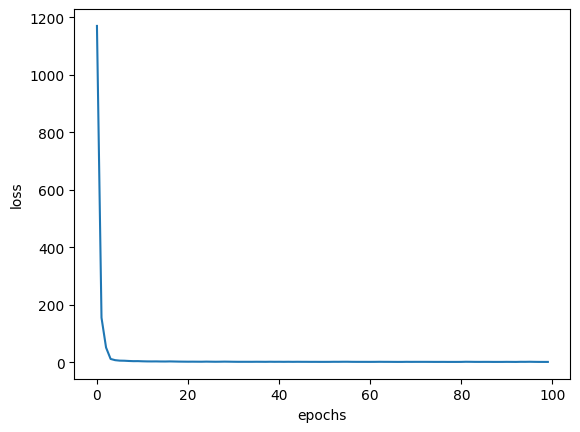

In [ ]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Saving the trained model

In [ ]:
#import tensorflow as tf

In [ ]:
#tf.keras.models.save_model(model,'brent.keras')

In [ ]:
from pickle5 import pickle
import joblib

arquivo_joblib = 'brent.joblib'
pickle.dump(model, open(arquivo_joblib, 'wb'))

### Loading a model
Please, load the model "brent_price_forecast_lstm_model" to evaluate it or make forecasts.

That model was trained with the following parameters:
- epochs = 100
- units = 150 (indicates the number of neurons in the LSTM layer)
- batch_size = 600
- activation = 'relu' (indicates the activation function in the LSTM layer)
- optimizer = 'adam'
- loss = 'mse'
- The data to feed the model was prepared with a window size of 30.

Neural network algorithms are stochastic, which means they make use of randomness, such as initializing to random weights, and in turn the same network, with the same hyperparameters, trained on the same data can produce different results [1]. This is the reason why it is necessary to load the aforementioned model.



[1] https://machinelearningmastery.com/stochastic-in-machine-learning

In [ ]:
# model = tf.keras.models.load_model('brent.keras')

In [ ]:
model = pickle.load(open(arquivo_joblib, 'rb'))

### Model testing

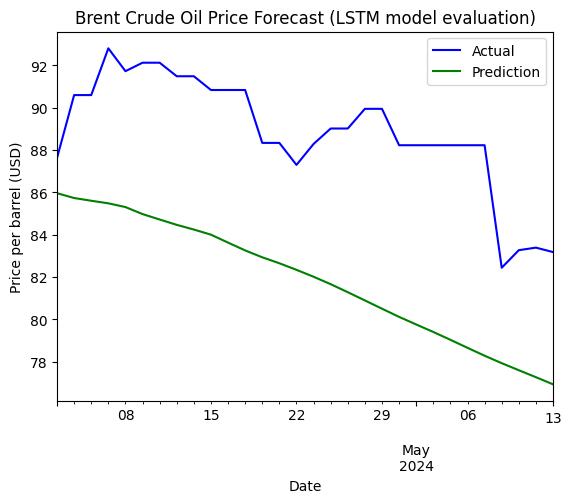

In [ ]:
prediction_set = []
batch_one = train_data_lstm[-ws:]
new_batch = batch_one.reshape((1, ws, 1))

for i in range(len(test_data)):
    pred = model.predict(new_batch, verbose=False)[0]
    prediction_set.append(pred)
    new_batch = np.append(new_batch[:, 1:, :], [[pred]], axis=1)

prediction_set = [i[0] for i in prediction_set] # Transforms a list of arrays into a list of single float items.
predictions = pd.Series(prediction_set, index=test_data.index)


# Plots the results
test_data.plot(color='blue', label='Actual')
predictions.plot(color='green', label='Prediction')

plt.title('Brent Crude Oil Price Forecast (LSTM model evaluation)')
plt.xlabel('Date')
plt.ylabel('Price per barrel (USD)')
plt.legend()
plt.show()

### Model evaluation

In [ ]:
rmse_lstm = np.sqrt(mean_squared_error(test_data_lstm, predictions))
mae_lstm = mean_absolute_error(test_data_lstm, predictions)
mape_lstm = mean_absolute_percentage_error(test_data_lstm, predictions)
print('Root Mean Square Error (RMSE): {} \nMean Absolute Error (MAE): {} \nMean Absolute Percentage Error (MAPE): {}'. format(np.round(rmse, 3), np.round(mae, 3), np.round(mape, 3)))

Root Mean Square Error (RMSE): 3.734 
Mean Absolute Error (MAE): 3.404 
Mean Absolute Percentage Error (MAPE): 0.038


### Using the model to forecast the Brent crude oil price for the following 30 days

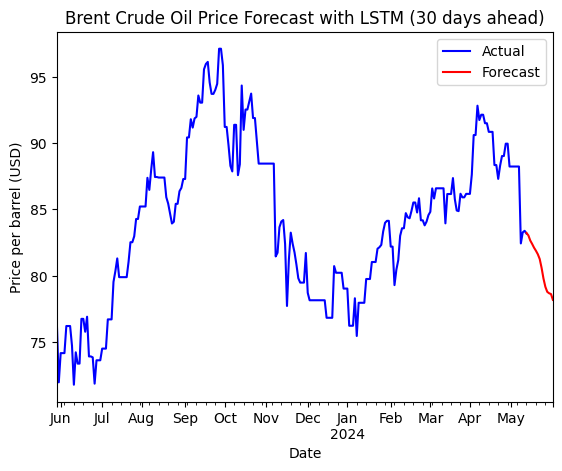

Forecasts for the following 15 days: 
2024-05-13    83.230377
2024-05-14    83.039993
2024-05-15    82.656891
2024-05-16    82.400101
2024-05-17    82.119102
2024-05-20    81.887894
2024-05-21    81.625870
2024-05-22    81.267242
2024-05-23    80.600288
2024-05-24    79.795570
2024-05-27    79.172302
2024-05-28    78.794899
2024-05-29    78.685585
2024-05-30    78.626534
2024-05-31    78.189682
Freq: B, Name: Forecast, dtype: float32


In [ ]:
# Makes the predictions
prediction_set = []
batch_one = full_data_lstm[-ws:]
new_batch = batch_one.reshape((1, ws, 1))
days_to_forecast = 15

for i in range(days_to_forecast):
    pred = model.predict(new_batch, verbose=False)[0]
    prediction_set.append(pred)
    new_batch = np.append(new_batch[:, 1:, :], [[pred]], axis=1)

prediction_set = [i[0] for i in prediction_set]  # Transforms a list of arrays into a list of single float items.
date_range = pd.date_range(test_data.index[-1], periods=days_to_forecast, freq='B')
forecast = pd.Series(prediction_set, index=date_range, name='Forecast')


# Displays results
short_data = data.iloc[-250:] # Last n datapoints of the original time series.

short_data.plot(color='blue', label='Actual')
forecast.plot(color='red')

plt.title('Brent Crude Oil Price Forecast with LSTM (30 days ahead)')
plt.xlabel('Date')
plt.ylabel('Price per barrel (USD)')
plt.legend()
plt.show()

print('Forecasts for the following {} days: '.format(days_to_forecast))
print(forecast)

In [ ]:
df_lstm = pd.DataFrame(forecast)

In [ ]:
df_lstm.index = pd.to_datetime(df_lstm.index, format = '%Y-%m-%d').strftime('%d/%m/%Y')


In [ ]:
df_lstm.rename(columns={"Forecast": "Forecast LSTM"}, inplace=True)

In [ ]:
df_lstm.head(15)

,Forecast LSTM
13/05/2024,83.230377
14/05/2024,83.039993
15/05/2024,82.656891
16/05/2024,82.400101
17/05/2024,82.119102
20/05/2024,81.887894
21/05/2024,81.625870
22/05/2024,81.267242
23/05/2024,80.600288
24/05/2024,79.795570


## Conclusão

In [ ]:
d = {' ' : ['RMSE','MAE', 'MAPE'] , 'SARIMA': [rmse, mae,mape], 'LSTM': [rmse_lstm, mae_lstm ,mape_lstm]}
df = pd.DataFrame(data=d)

print(df)

           SARIMA      LSTM
0  RMSE  3.733864  7.167438
1   MAE  3.403904  6.945337
2  MAPE  0.038064  0.078090


In [ ]:
df = pd.concat([df_arima, df_lstm], axis=1)

In [ ]:
df.head(14)

,Forecast ARIMA,Forecast LSTM
14/05/2024,83.188632,83.039993
15/05/2024,83.175863,82.656891
16/05/2024,83.163095,82.400101
17/05/2024,83.150330,82.119102
20/05/2024,83.137566,81.887894
21/05/2024,83.124804,81.625870
22/05/2024,83.112045,81.267242
23/05/2024,83.099287,80.600288
24/05/2024,83.086531,79.795570
27/05/2024,83.073778,79.172302
